In [20]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras 
from keras.models import *
from keras.layers import *

from keras.callbacks import EarlyStopping

In [21]:
directory = '/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
data_df = pd.DataFrame(columns=['directory', 'class'])
for filename in os.listdir(directory):
    print(filename)
    for img in os.listdir(directory+"/"+filename):
        #print(img)
        data_df = data_df.append({'directory':directory+"/"+filename+"/"+img, 
                                 'class':filename}, ignore_index = True)

pneumonia
normal
covid


                                              directory      class
1599  /kaggle/input/augmented-xray-dataset/COVID19_P...     normal
662   /kaggle/input/augmented-xray-dataset/COVID19_P...  pneumonia
3086  /kaggle/input/augmented-xray-dataset/COVID19_P...      covid
3001  /kaggle/input/augmented-xray-dataset/COVID19_P...     normal
433   /kaggle/input/augmented-xray-dataset/COVID19_P...  pneumonia
covid 2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg
(1127, 1300, 3)


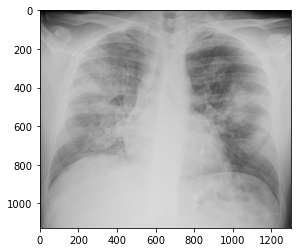

In [22]:
data_df = data_df.sample(frac = 1, random_state=7)
print(data_df.head(5))

test_img_path = data_df.iloc[2][0]
test_img = cv2.imread(test_img_path)
print(test_img_path.split("/")[-2], test_img_path.split("/")[-1])
print(test_img.shape)
plt.imshow(test_img)

In [23]:
batch_size = 24
size = (224,224,3)
img_width = img_hight = size[0]
random_state = 7

classes = list(data_df['class'].unique())



In [24]:
from sklearn.model_selection import train_test_split

train_df , val_test_df , train_class , val_test_class = train_test_split(data_df, data_df['class'], train_size=0.7, random_state=7, stratify=data_df['class'])
val_df , test_df , val_class , test_class = train_test_split(val_test_df, val_test_class, train_size=0.5, random_state=7, stratify=val_test_class)

print("Train Split :", round((train_df.shape[0] / data_df['directory'].shape[0]),3))
print("Validation Split :",round((val_df.shape[0] / data_df['directory'].shape[0]),3))
print("Test Split :",round((test_df.shape[0] / data_df['directory'].shape[0]),3))

print("training images :" ,len(train_df))
print("validation images :",len(val_df))
print("testing images :",len(test_df))

Train Split : 0.7
Validation Split : 0.15
Test Split : 0.15
training images : 3202
validation images : 686
testing images : 687


In [25]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = data_gen.flow_from_dataframe(train_df, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes, subset=None, validate_filenames= False,seed=42)

#Validation Data Generator
val_data = data_gen.flow_from_dataframe(val_df, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes, subset=None, validate_filenames= False,seed=42)

#Test Data Generator
test_data = data_gen.flow_from_dataframe(test_df, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes, subset=None, validate_filenames= False, seed=42)


Found 3202 non-validated image filenames belonging to 3 classes.
Found 686 non-validated image filenames belonging to 3 classes.
Found 687 non-validated image filenames belonging to 3 classes.


In [26]:
def Create_model(Image_shape, block1=True, block2=True, block3=True,
                 block4=True, block5=True, lstm=True, regularizer=keras.regularizers.l2(0.0001),
                 Dropout_ratio=0.15):

    # * Create the model
    model = keras.Sequential()

    # * configure the inputshape
    model.add(keras.Input(shape=Image_shape))

    # * Add the first block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu',
              trainable=block1, kernel_regularizer=regularizer))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu',
              trainable=block1, kernel_regularizer=regularizer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # * Add the second block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu',
              trainable=block2, kernel_regularizer=regularizer))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu',
              trainable=block2, kernel_regularizer=regularizer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # * Add the third block
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu',
              trainable=block3, kernel_regularizer=regularizer))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu',
              trainable=block3, kernel_regularizer=regularizer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # * Add the fourth block
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block4, kernel_regularizer=regularizer))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block4, kernel_regularizer=regularizer))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block4, kernel_regularizer=regularizer))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # * Add the fifth block
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block5, kernel_regularizer=regularizer))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block5, kernel_regularizer=regularizer))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block5, kernel_regularizer=regularizer))
    
    model.add((MaxPooling2D(pool_size=(2, 2))))
    model.add(BatchNormalization())

    # * Reshape the output of the last layer to be used in the GRU layer
    model.add(keras.layers.Reshape((7*7, 512)))
    #model.add(GRU(512, activation='relu', trainable=lstm, return_sequences=True))
    model.add(LSTM(512, activation='relu', trainable=lstm, return_sequences=True))
    model.add(BatchNormalization())

    #* flatten + Fc layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(Dropout_ratio))
    model.add(BatchNormalization())
    
    # * Output layer
    #model.add(Dense(3, activation='linear'))
    model.add(Dense(3, activation='sigmoid'))
    print('Done')
    return model
model = Create_model(size)


Done


In [40]:
model.compile( loss = 'categorical_crossentropy', optimizer = SGD(lr=0.0001, decay=1e-7, ),metrics=['accuracy'])

In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


SavingModel = ModelCheckpoint(filepath='paper_model.h5', 
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=False)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 30,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=6, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

callbacks = [ SavingModel, earlystop, learning_rate_reduction]

In [41]:
results = model.fit(
    train_data, 
    validation_data= val_data, 
    epochs=120, 
    callbacks=callbacks)

Epoch 1/120
134/134 [==============================] - 83s 602ms/step - loss: 0.9817 - accuracy: 0.7661 - val_loss: 1.4714 - val_accuracy: 0.3513

Epoch 00001: val_accuracy improved from -inf to 0.35131, saving model to paper_model.h5
Epoch 2/120
134/134 [==============================] - 81s 604ms/step - loss: 0.8186 - accuracy: 0.8314 - val_loss: 1.7832 - val_accuracy: 0.3338

Epoch 00002: val_accuracy did not improve from 0.35131
Epoch 3/120
134/134 [==============================] - 80s 595ms/step - loss: 0.7491 - accuracy: 0.8691 - val_loss: 2.3324 - val_accuracy: 0.3324

Epoch 00003: val_accuracy did not improve from 0.35131
Epoch 4/120
134/134 [==============================] - 79s 590ms/step - loss: 0.7045 - accuracy: 0.8832 - val_loss: 1.2524 - val_accuracy: 0.6283

Epoch 00004: val_accuracy improved from 0.35131 to 0.62828, saving model to paper_model.h5
Epoch 5/120
134/134 [==============================] - 79s 584ms/step - loss: 0.6487 - accuracy: 0.9082 - val_loss: 0.8060 

In [42]:
pd.DataFrame.to_csv(pd.DataFrame(results.history),'paper_lstm_his.csv', index=False)

Text(0, 0.5, 'losses')

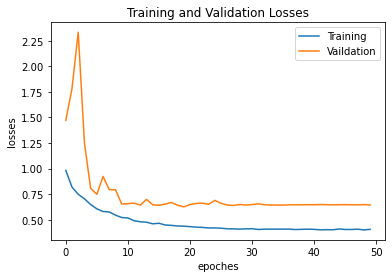

In [43]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Training','Vaildation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoches')
plt.ylabel('losses')

Text(0, 0.5, 'accuracy')

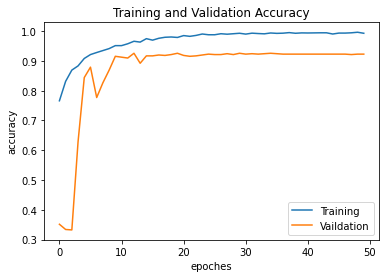

In [44]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['Training','Vaildation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.ylabel('accuracy')

In [45]:
model.save('GP_paper.h5')